# Проект №9: Временные ряды

**Описание проекта:**

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта:** Построить модель для прогнозирования заказов такси на следующий час.

**Инструкция по выполнению проекта:**
1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

**Примечание:** Значение метрики RMSE на тестовой выборке должно быть не больше 48.

**Описание данных:**

Данные лежат в файле 'taxi.csv'.  Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

**План работы с проектом:**
1. Загрузка и подготовка данных;
2. Анализ данных;
3. Обучение моделей;
4. Тестирование моделей;
5. Формирование итоговых выводов.

## 1. Загрузка и подготовка данных

In [1]:
# загрузим стандартные библиотеки, необходимые для работы
import pandas as pd
import math
import sklearn
import numpy as np
from scipy import stats as st

# загрузим библиотеки для визуализации данных
import matplotlib.pyplot as plt 
import seaborn as sns

# загрузим модули для работыы над конкретной задачей
from datetime import datetime
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
import time

import warnings
warnings.filterwarnings("ignore")

# зададим константу
RANDOM_STATE = 42

In [2]:
# загрузим данные и посмотрим общую информацию о них
try:
    # локальный путь к файлу
    taxi = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Временные_ряды/taxi.csv')
except:
    # путь к файлу в тренажере
    taxi = pd.read_csv('/datasets/taxi.csv')

# посмотрим первые 5 строк датафрема
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [3]:
# посмотрим общую информацию о таблице
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


**Примечание:** При первичном осмотре данных видно, значения в столбцах соответствуют описанию задачи, что пропуски отсутствуют. Тип данных в столбце 'datetime' определ неверно, необходимо заменить. Также сразу заменим индексы на значения столбца 'datetime'.

In [4]:
# загрузим данные и посмотрим общую информацию о них
try:
    # локальный путь к файлу
    taxi = pd.read_csv('C:/Users/Admin/OneDrive/Рабочий стол/ПФ/Временные_ряды/taxi.csv', index_col='datetime', parse_dates=[0])
except:
    # путь к файлу в тренажере
    taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

# посмотрим первые 5 строк датафрема
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
# посмотрим общую информацию о таблице
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# посмотрим, расположены ли данные в хронологическом порядке (монотонно возрастают)
taxi.index.is_monotonic_increasing

True

In [7]:
# проведем сортировку индексов в таблице (на всякий случай)
taxi = taxi.sort_index()

In [8]:
# проведем ресемплирование данных по одному часу
# т.к. предсказываем кол-во заказов такси на следующий час, то возьмем агрегирующую функцию - сумму
taxi = taxi.resample('1H').sum()

In [9]:
# посмотрим получившийся временной промежуток
print(f'Временной промежуток данных: {taxi.index.min()} - {taxi.index.max()}')

Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00


**Обобщающий вывод этапа "Загрузка и подготовка данных":**
1. Данные соответствуют описанию задачи, пропуски отсутствуют.
2. Изменен тип данных в столбце 'datetime'.
3. Индексы заменены на значения столбца 'datetime.
4. Даты расположены в хронологическом порядке и просемплированы по одному часу (по условию задачи).

## 2. Анализ данных

Для начала посмотрим различные характеристикивременного ряда за весь период с марта по август 2018 года.

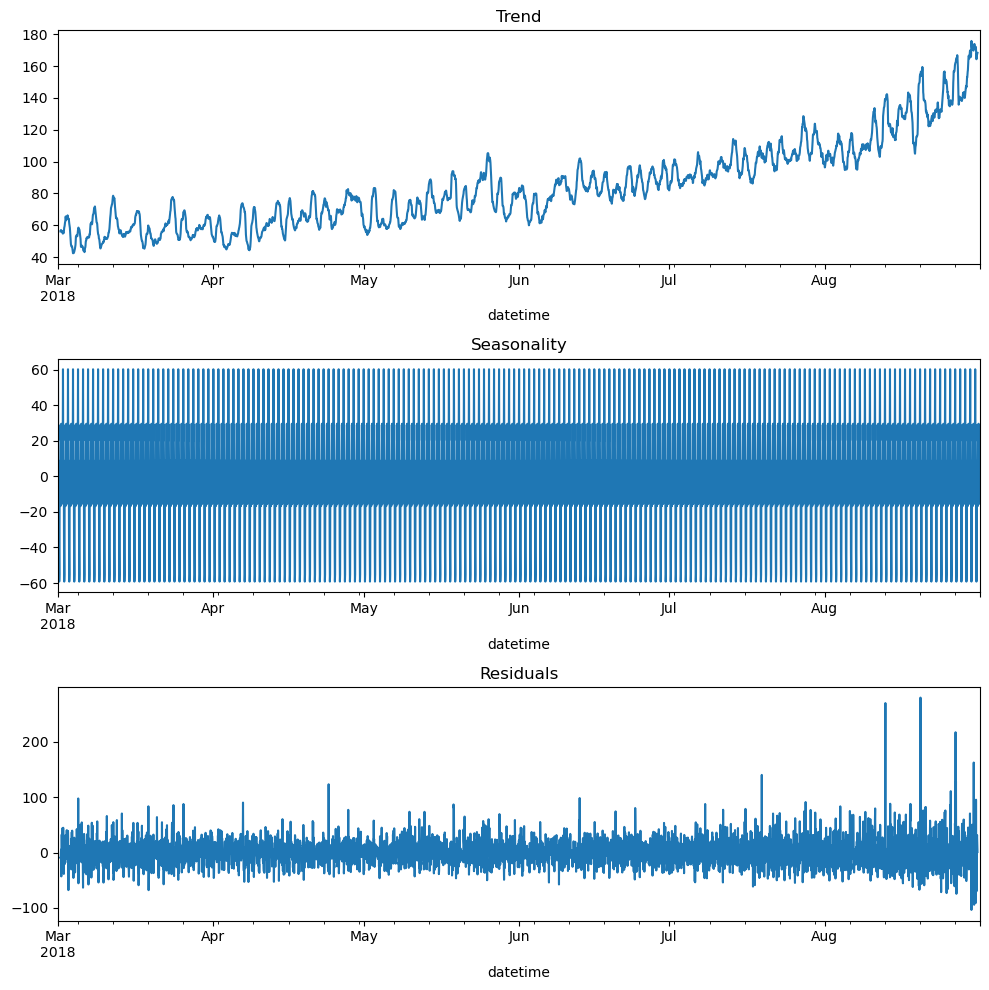

In [10]:
decomposed = seasonal_decompose(taxi)

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Примечание:** 
1. График тренда имеет восходящий характер, указывающий на увеличение количества заказов по месяцам, но в то же время видны различные спады и всплески, которые уже могут быть связаны с неделями и определенными днями недели. Наблюдаетмя наличие некоторого шума в линии тренда.
2. график сезонности показывает взаимосвязь по неделям, т.к. присутствует некоторое количество повторяющихся элементов графика.
3. Заметны небольшие признаки нестационарности временного ряда, т.к. со временем присутствуют изменения среднего значения.

Посмотрим различные характеристики временного ряда за последний месяц временного промежутка данных (август 2018 года), а именно: тренд, сезонную составляющую и остаток декомпозиции.

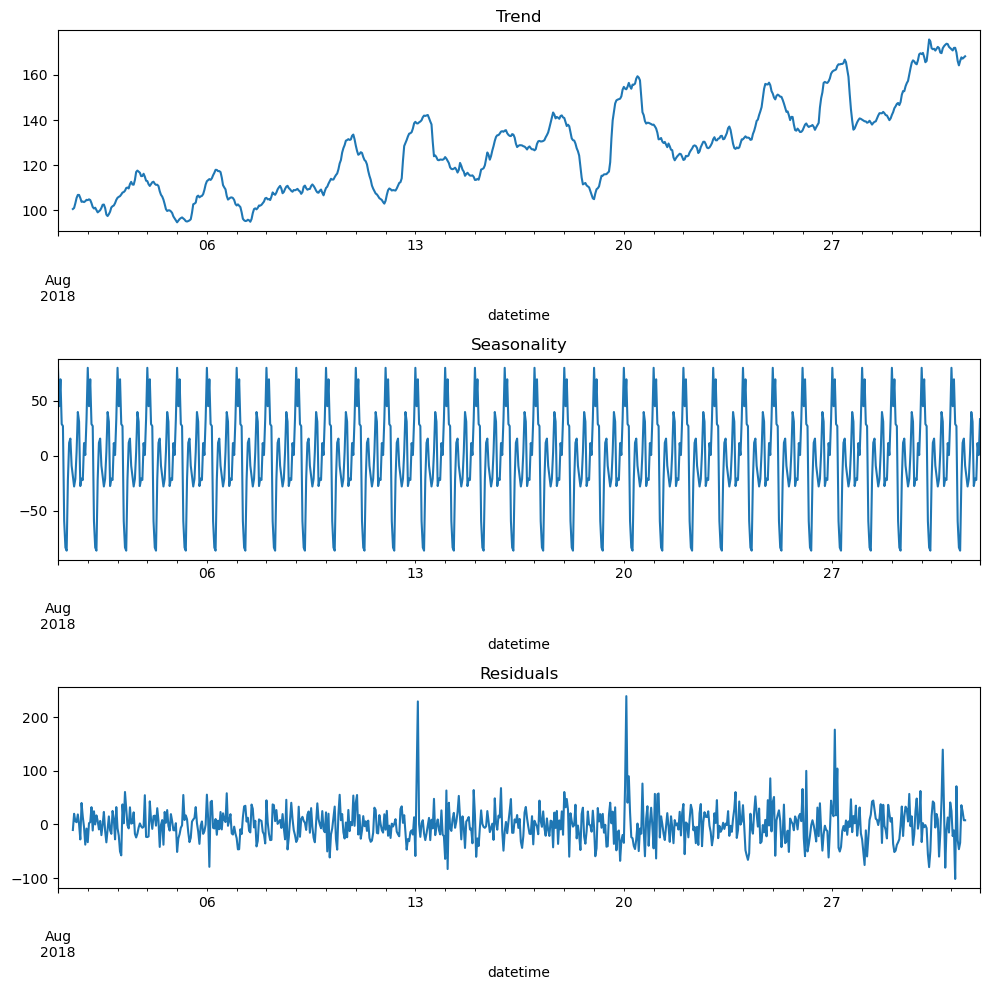

In [11]:
decomposed = seasonal_decompose(taxi['2018-08':'2018-08'])

plt.figure(figsize=(10, 10))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

**Обобщающий вывод этапа "Анализ данных":**
1. График тренда за последний месяц (август 2018 года) показывает постепенное увеличение количества заказав с начала к концу месяца. Также можно увидеть некоторые спады за этот промежуток каждые 7 дней. Можно сделать предположение о том, что на выходных (в воскресенье) количество заказов такси падало, а к понедельнику снова значительно возрастало.
2. График сезонности за период суток на первый взгляд выглядит статичным в интервале суток.
3. График остатков на первый взгляд указывает на нестационарность временного ряда, т.к. среднее значение иногда изменяется в силу значительных всплесков, которые обусловлены изменением спроса на такси.

## 3. Обучение моделей

### 3.1 Создание новых признаков

In [12]:
# напишем собственную функцию для создания новых признаков
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['hour'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

    return df

In [13]:
# создадим таблицу для обучения с новыми признаками
data = make_features(taxi, 30, 50)

### 3.2 Подготовка данных для обучения моделей

In [14]:
# разделим данные на тестовую и тренировочные выборки в соотношении 9:1 (по условию задачи: 10% - тестовая выборка)
train, test = train_test_split(data, shuffle=False, test_size=0.1)

# удалим образовавшиеся пропуски
train = train.dropna()

In [15]:
# посмотрим первые 5 строк получившейся тренировочной выборки
train.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,3,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,3,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,3,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,3,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,3,5,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86


In [16]:
# выделем целевой и обычные признаки
X_train = train.drop(columns='num_orders')
y_train = train['num_orders']
X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

In [17]:
# создадим таблицу, в которую будем записывать все результаты для последующего анализа
results = pd.DataFrame(columns=['Среднее RMSE', 'Среднее время обучения (с)', 'Среднее время предсказания (с)'])

In [18]:
# напишем собственную функцию для расчета времени обучения, предсказания и RMSE (с использованием кросс-валидации)
def record_cv(model, result_df, X, y, n_splits=5):
    model_name = model.__class__.__name__
    # инициализируем метод кросс-валидации для временных рядов
    tscv = TimeSeriesSplit(n_splits=n_splits)

    rmses = []
    fit_times = []
    pred_times = []
    
    # разделение данных с учетом кросс-валидации
    for train_idx, val_idx in tscv.split(X):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # обучение модели и замер времени для этого
        start_fit = datetime.now()
        model.fit(X_train, y_train)
        end_fit = datetime.now()

        # предсказание модели и замер времени для этого
        start_pred = datetime.now()
        y_pred = model.predict(X_val)
        end_pred = datetime.now()

        # расчет метрики
        rmse = mean_squared_error(y_val, y_pred, squared=False)

        # сохранение результатов
        rmses.append(rmse)
        fit_times.append((end_fit - start_fit).total_seconds())
        pred_times.append((end_pred - start_pred).total_seconds())

    # запись всех результатов в окончательную таблицу
    result_df.loc[model_name] = [
        np.mean(rmses),
        np.mean(fit_times),
        np.mean(pred_times)
    ]

    # вывод информации о модели
    print(f'Модель {model_name}, Среднее RMSE = {np.mean(rmses):.4f}')
    
    return model

### 3.3 Модель LinearRegression

In [19]:
# инициализируем модель
linear_model = LinearRegression()

# применим функцию
record_cv(linear_model, results, X_train, y_train)

Модель LinearRegression, Среднее RMSE = 26.6726


LinearRegression()

### 3.4 Модель RandomForestRegressor

In [20]:
# подберем наилучшие гиперпараметры для модели
# rfr_parameters = {'n_estimators': range(100, 251, 25),
                  # 'max_depth': range(10, 20, 2),
                  # 'random_state': [13],
                  # 'n_jobs': [-1]
                 # }

In [21]:
# самостоятельно создадим метрику для оценки качества модели
# def RMSE(y_true, y_pred):
    # return (mean_squared_error(y_true, y_pred) ** 0.5)

# scorer_rmse = make_scorer(RMSE, greater_is_better=False)

In [22]:
# инициализируем модель
# rfr_model = RandomForestRegressor()

In [23]:
# %%time
# tscv = TimeSeriesSplit(n_splits=5)

# grid_rfr = GridSearchCV(rfr_model,
                        # rfr_parameters,
                        # scoring=scorer_rmse,
                        # cv=tscv.split(X_train))
# grid_rfr.fit(X_train, y_train)
# grid_rfr.best_params_

**Примечание:** Был проведен подбор гиперпараметров для модели RandomForestRegressor(), но он производится около 30 минут, поэтому для ускорения запуска кода, часть с реализацией подбора была закомментирована. В дальнейшем гиперпараметры для моделей будут подбираться вручную.

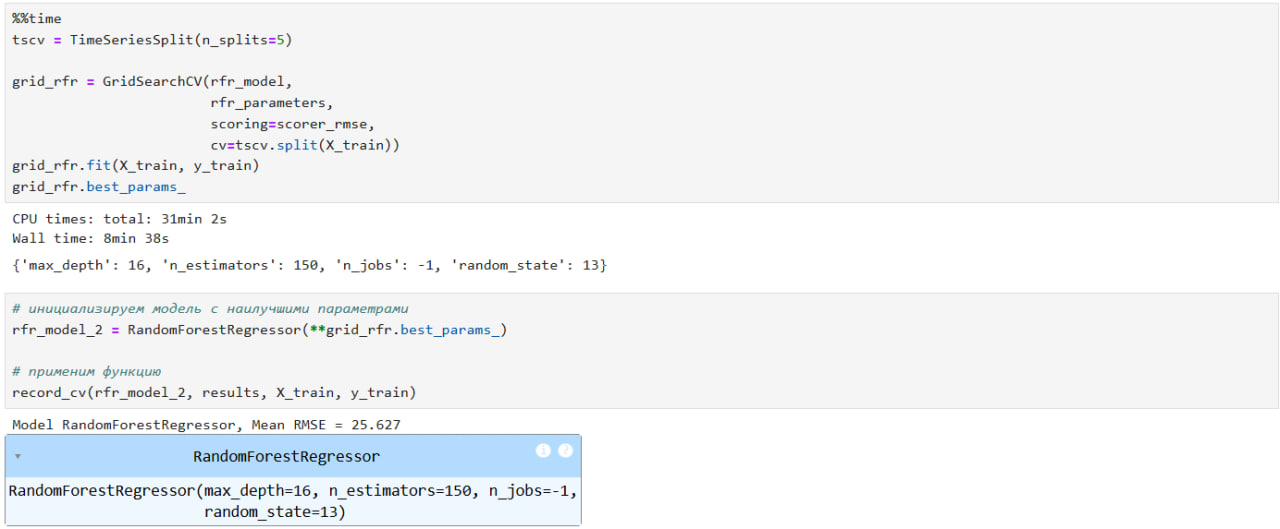

In [24]:
# инициализируем модель с наилучшими параметрами (получены с помощью закомментированного кода (см. фото выше))
rfr_model_2 = RandomForestRegressor(max_depth=16, n_estimators=150, n_jobs=-1, random_state=13)

# применим функцию
record_cv(rfr_model_2, results, X_train, y_train)

Модель RandomForestRegressor, Среднее RMSE = 25.6271


RandomForestRegressor(max_depth=16, n_estimators=150, n_jobs=-1,
                      random_state=13)

### 3.5 Модель CatBoostRegressor

In [25]:
# зададим параметры для модели вручную, чтобы не тратить много времени на поиск наилучших (исключительно в целях реализации проекта)
# инициализируем модель
cat_model = CatBoostRegressor(learning_rate=0.1, random_state=RANDOM_STATE, verbose=100)

# применим функцию
record_cv(cat_model, results, X_train, y_train)

0:	learn: 28.0291167	total: 152ms	remaining: 2m 32s
100:	learn: 10.6649585	total: 1.24s	remaining: 11s
200:	learn: 6.2697556	total: 2s	remaining: 7.97s
300:	learn: 3.9380600	total: 2.76s	remaining: 6.4s
400:	learn: 2.4517865	total: 3.51s	remaining: 5.25s
500:	learn: 1.4741085	total: 4.27s	remaining: 4.25s
600:	learn: 0.8927421	total: 5.03s	remaining: 3.34s
700:	learn: 0.5471531	total: 5.79s	remaining: 2.47s
800:	learn: 0.3433939	total: 6.57s	remaining: 1.63s
900:	learn: 0.2204834	total: 7.34s	remaining: 807ms
999:	learn: 0.1374072	total: 8.11s	remaining: 0us
0:	learn: 29.0971829	total: 13.7ms	remaining: 13.7s
100:	learn: 13.3678350	total: 950ms	remaining: 8.46s
200:	learn: 9.4339702	total: 1.83s	remaining: 7.29s
300:	learn: 6.9266365	total: 2.68s	remaining: 6.23s
400:	learn: 5.1320148	total: 3.56s	remaining: 5.33s
500:	learn: 3.9454970	total: 4.45s	remaining: 4.43s
600:	learn: 3.0259883	total: 5.3s	remaining: 3.52s
700:	learn: 2.3326740	total: 6.13s	remaining: 2.62s
800:	learn: 1.76801

### 3.6 Модель LightGBM

In [26]:
# зададим параметры для модели вручную, чтобы не тратить много времени на поиск наилучших (исключительно в целях реализации проекта)
# инициализируем модель
lgb_model = lgb.LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=RANDOM_STATE, n_jobs=-1)

# применим функцию
record_cv(lgb_model, results, X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3291
[LightGBM] [Info] Number of data points in the train set: 654, number of used features: 33
[LightGBM] [Info] Start training from score 56.611621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

LGBMRegressor(n_jobs=-1, random_state=42)

**Обобщающий вывод этапа "Обучение моделей":**
1. Для обучения моделей с помощью собственной функции были созданы новые признаки.
2. Полученная для обучения моделей таблица была разбита на тренировочную и тестовую выборки.
3. С помощью кросс-валидации были обучены модели LinearRegression, RandomForestRegressor, CatBoostRegressor, LightCBM, а также рассчитаны время обучения и предсказания моделей и метрика оценки качества RMSE.

## 4. Тестирование моделей

In [27]:
# посмотрим тпблицу, полученную после обучения всех моделей
results.sort_values(by='Среднее RMSE')

,Среднее RMSE,Среднее время обучения (с),Среднее время предсказания (с)
CatBoostRegressor,24.939416,10.353699,0.011975
RandomForestRegressor,25.627059,5.474043,0.078486
LGBMRegressor,25.741829,0.252881,0.010098
LinearRegression,26.672610,0.009562,0.004794


**Примечание:** Лучшей моделью по метрике оценки качества RMSE оказалась CatBoostRegressor, однако, у нее достаточно долгое время обучения модели, следующие за ней две модели RandomForestRegressor и LGBMRegressor показали метрику оценки качества чуть ниже, чем у CatBoostRegressor, но с более быстрым временем обучения и предсказания. Так как по условию задачи стоит сделать акцент на оценку метрики качества RMSE, то для предсказания возьмем модель CatBoostRegressor.

In [28]:
# выбираем лучшую модель
best_model = CatBoostRegressor(learning_rate=0.1, random_state=RANDOM_STATE, verbose=100)
best_model.fit(X_train, y_train)

0:	learn: 37.0746793	total: 13.3ms	remaining: 13.3s
100:	learn: 20.2792186	total: 1.26s	remaining: 11.2s
200:	learn: 16.6381529	total: 2.51s	remaining: 9.98s
300:	learn: 14.2228339	total: 3.78s	remaining: 8.78s
400:	learn: 12.4204158	total: 5.04s	remaining: 7.53s
500:	learn: 10.9662606	total: 6.29s	remaining: 6.26s
600:	learn: 9.6765228	total: 7.55s	remaining: 5.01s
700:	learn: 8.6078688	total: 8.82s	remaining: 3.76s
800:	learn: 7.6365649	total: 10.1s	remaining: 2.51s
900:	learn: 6.7939212	total: 11.4s	remaining: 1.25s
999:	learn: 6.0870659	total: 12.6s	remaining: 0us


In [29]:
%%time
start_pred = time.time()
y_pred = best_model.predict(X_test)
end_pred = time.time() - start_pred

CPU times: total: 46.9 ms
Wall time: 13.2 ms


In [30]:
# расчет RMSE на тестовой выборке
rmse_test = mean_squared_error(y_test, y_pred, squared=False)

# вывод итоговых результатов
print(f"RMSE на тесте: {rmse_test:.4f}")
print(f"Время предсказания: {end_pred:.4f} секунд")

RMSE на тесте: 42.6002
Время предсказания: 0.0132 секунд


**Примечание:** Полученная оценка метрики качества RMSE равна 42.6002, что полностью удобвлетворяет условию задачи: "Значение метрики RMSE на тестовой выборке должно быть не больше 48".

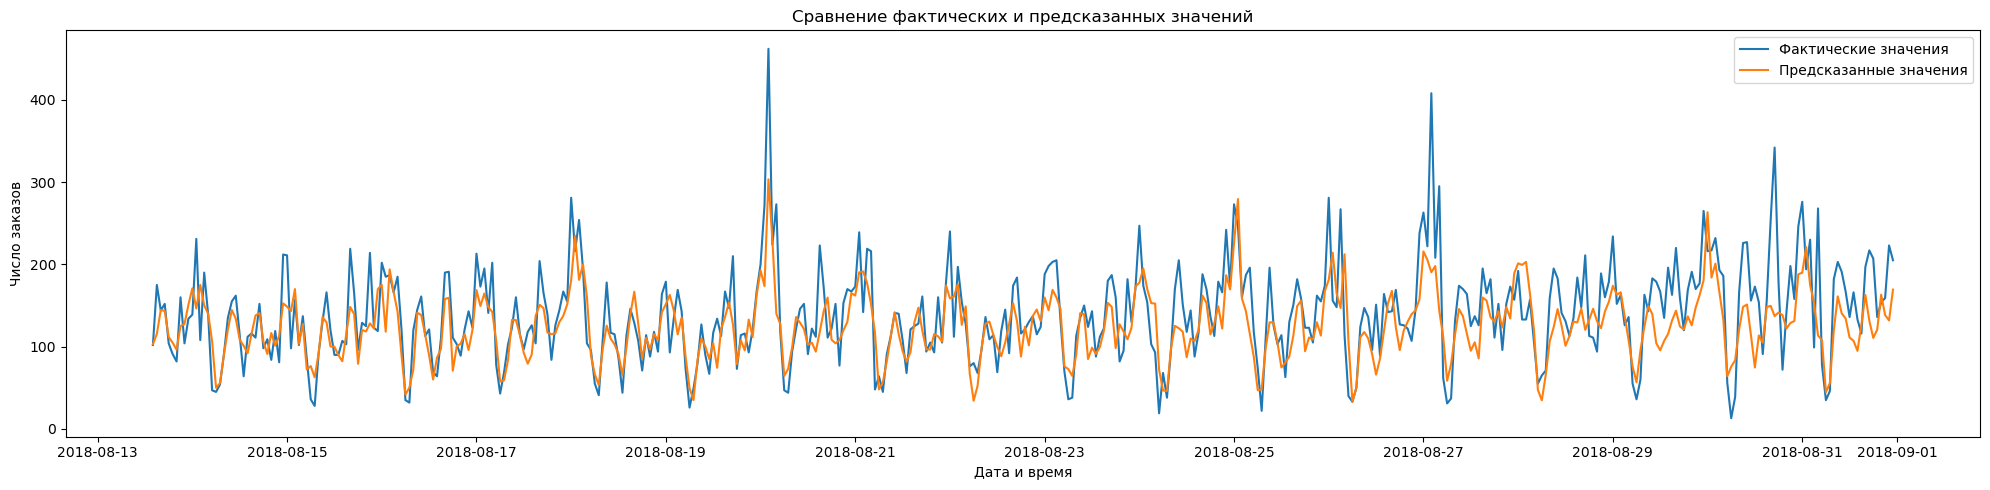

In [31]:
# визуализируем полученные результаты
plt.figure(figsize=(20, 5))

plt.plot(y_test.index, y_test, label='Фактические значения')
plt.plot(y_test.index, y_pred, label='Предсказанные значения')

plt.title('Сравнение фактических и предсказанных значений')
plt.xlabel('Дата и время')
plt.ylabel('Число заказов')
plt.legend()
plt.tight_layout()
plt.show()

**Обобщающий вывод этапа "Тестирование моделей":**
1. На данном этапе была выбрана лучшая модель поле обучения всех моделей, такой оказалась CatBoostRegressor, которая показала наилучшее значение метрики качества RMSE на кросс-валидации, равное 24.939416.
2. На основе лучшей модели было выполнено предсказание на тестовой выборке, которое показала значение метрики оценки качества, равное 42.6002, что полностью удобвлетворяет условию задачи: "Значение метрики RMSE на тестовой выборке должно быть не больше 48".
3. Проведена визуализация временного ряда по фактическим и предсказанным значениям.

## 5. Итоговые выводы

В ходе работы были проанализированы данные, предоставленные компанией "Чётенькое такси", которая хочет разработать модель, позволяющую предсказывать количество заказов такси на следующий час.

Для реализации этой задачи было выполнено 4 этапа работы.

На **1 этапе: Загрузка и подготовка данных** были проанализированы все исходные данные и получены следующие результаты:
1. Данные соответствуют описанию задачи, пропуски отсутствуют.
2. Изменен тип данных в столбце 'datetime'.
3. Индексы заменены на значения столбца 'datetime.
4. Даты расположены в хронологическом порядке и просемплированы по одному часу (по условию задачи).

На **2 этапе: Анализ данных** были получены следующие результаты:
1. График тренда за последний месяц (август 2018 года) показывает постепенное увеличение количества заказав с начала к концу месяца. Также можно увидеть некоторые спады за этот промежуток каждые 7 дней. Можно сделать предположение о том, что на выходных (в воскресенье) количество заказов такси падало, а к понедельнику снова значительно возрастало.
2. График сезонности за период суток на первый взгляд выглядит статичным в интервале суток.
3. График остатков на первый взгляд указывает на нестационарность временного ряда, т.к. среднее значение иногда изменяется в силу значительных всплесков, которые обусловлены изменением спроса на такси.

На **3 этапе: Обучение моделей** было сделано:
1. Для обучения моделей с помощью собственной функции были созданы новые признаки.
2. Полученная для обучения моделей таблица была разбита на тренировочную и тестовую выборки.
3. С помощью кросс-валидации были обучены модели LinearRegression, RandomForestRegressor, CatBoostRegressor, LightCBM, а также рассчитаны время обучения и предсказания моделей и метрика оценки качества RMSE.

На **4 этапе: Тестирование моделей** было сделано:
1. На данном этапе была выбрана лучшая модель поле обучения всех моделей, такой оказалась CatBoostRegressor, которая показала наилучшее значение метрики качества RMSE на кросс-валидации, равное 24.939416.
2. На основе лучшей модели было выполнено предсказание на тестовой выборке, которое показала значение метрики оценки качества, равное 42.6002, что полностью удобвлетворяет условию задачи: "Значение метрики RMSE на тестовой выборке должно быть не больше 48".
3. Проведена визуализация временного ряда по фактическим и предсказанным значениям.

**Таким образом**, наилучшей моделью для предсказания количества заказов такси на следующий час является CatBoostRegressor с метрикой оценки качества на тестовой выборке, равной 42.6002, что полностью удобвлетворяет условию задачи: "Значение метрики RMSE на тестовой выборке должно быть не больше 48".